In [1]:
from IPython.display import display
import itertools
from lightgbm import LGBMClassifier
import logging
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.svm import SVC


_logger = logging.getLogger(__name__)
_logger.setLevel(logging.INFO)
_formatter = logging.Formatter(
    "%(asctime)s:%(levelname)s:%(module)s: %(message)s"
)
_console_handler = logging.StreamHandler()
_console_handler.setFormatter(_formatter)
_logger.addHandler(_console_handler)


from birdwatcher.config import paths, secrets, training_config
from birdwatcher.ml.PCAPlotIt import PCAPlotIt
from birdwatcher.ml.utils import get_model_performance_metrics, gs_display_save_results, s3_load_pickle

In [2]:
# Load sentiment140 df_tfidf.
sent140_tfidf = pd.read_parquet(paths.sentiment140_path_tfidf)
sent140_tfidf.target = (sent140_tfidf.target / 4).astype(int)
sent140_tfidf.head(3)

,target,01,026,04,0430,07,08,0809,0815,09,...,zoya,zune,zunehd,zurich,zushi,zwolle,zzz,zzzzz,zzzzzzzzlullaby,zzzzzzzzzzz
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Split the train/test data.
y_cols = "target"
x_cols = list(sent140_tfidf.columns)
x_cols.remove(y_cols)
x_tfidf = sent140_tfidf[x_cols]
y_tfidf = sent140_tfidf[y_cols]
x_train, x_test, y_train, y_test = train_test_split(
    x_tfidf, 
    y_tfidf, 
    test_size = training_config.train_test_info["test_size"],
    random_state = training_config.train_test_info["random_state"]
)

# Logistic Regression

In [4]:
# Build logistic regression classifier.
logit_classifier = LogisticRegression(
    random_state=0,
    penalty="elasticnet",
    l1_ratio=0.5,
    solver="saga",
    n_jobs=-1
)
logit_classifier.fit(x_train, y_train)

get_model_performance_metrics(
    clf=logit_classifier,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:04:01,390:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:04:01,395:INFO:utils:Accuracy: 0.7140549273021002
2023-05-07 20:04:01,398:INFO:utils:ROC AUC: 0.7864443289617462
2023-05-07 20:04:01,401:INFO:utils:Confusion matrix:
[[638 296]
 [235 688]]
2023-05-07 20:04:01,407:INFO:utils:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       934
           1       0.70      0.75      0.72       923

    accuracy                           0.71      1857
   macro avg       0.72      0.71      0.71      1857
weighted avg       0.72      0.71      0.71      1857

2023-05-07 20:04:01,408:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:04:20,260:INFO:utils:Cross-validated precision: 0.7092008050175773
2023-05-07 20:04:36,972:INFO:utils:Cross-validated recall: 0.7575345849802371
2023-05-07 20:04:53,371:INFO:utils:Cro

In [5]:
# Apply grid search to tune hyperparameters.
l1_ratio_list = [(l1_ratio / 20) for l1_ratio in list(range(0, 21))]
parameters_logit = {"l1_ratio" : l1_ratio_list}
logit_final = GridSearchCV(
    LogisticRegression(penalty="elasticnet", solver="saga", n_jobs=-1),
    parameters_logit,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)
logit_final.fit(x_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'l1_ratio': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                      0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
                                      0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]},
             scoring='f1_macro', verbose=1)

In [6]:
# Get and display best results.
best_parameters_gs = gs_display_save_results(
    gscv_fit=logit_final, 
    file_prefix="logreg", 
    save=True
)
best_model = logit_final.best_estimator_

,Params,Mean out-of-bag F1
0,{'l1_ratio': 0.0},0.729058
1,{'l1_ratio': 0.05},0.727427
2,{'l1_ratio': 0.1},0.727825
3,{'l1_ratio': 0.15},0.729292
4,{'l1_ratio': 0.2},0.728596


,Params,Mean out-of-bag F1
16,{'l1_ratio': 0.8},0.723321
17,{'l1_ratio': 0.85},0.722322
18,{'l1_ratio': 0.9},0.721869
19,{'l1_ratio': 0.95},0.720852
20,{'l1_ratio': 1.0},0.719523


2023-05-07 20:06:15,239:INFO:utils:Best parameters: {'l1_ratio': 0.25}. Best mean out-of-bag F1: 0.7296721036445458


In [7]:
get_model_performance_metrics(
    clf=best_model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:06:15,540:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:06:15,542:INFO:utils:Accuracy: 0.7135164243403339
2023-05-07 20:06:15,545:INFO:utils:ROC AUC: 0.7901922322934478
2023-05-07 20:06:15,548:INFO:utils:Confusion matrix:
[[652 282]
 [250 673]]
2023-05-07 20:06:15,554:INFO:utils:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       934
           1       0.70      0.73      0.72       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.71      1857
weighted avg       0.71      0.71      0.71      1857

2023-05-07 20:06:15,560:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:06:37,516:INFO:utils:Cross-validated precision: 0.7181219871007907
2023-05-07 20:06:57,844:INFO:utils:Cross-validated recall: 0.7499314199752227
2023-05-07 20:07:18,899:INFO:utils:Cro

# Random Forest

In [8]:
# Instantiate, fit and evaluate a random forest classifier.
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=123
)
rf_classifier.fit(x_train, y_train)

get_model_performance_metrics(
    clf=rf_classifier,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:08:06,369:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:08:06,371:INFO:utils:Accuracy: 0.69520732364028
2023-05-07 20:08:06,374:INFO:utils:ROC AUC: 0.7689367136768892
2023-05-07 20:08:06,375:INFO:utils:Confusion matrix:
[[595 339]
 [227 696]]
2023-05-07 20:08:06,380:INFO:utils:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       934
           1       0.67      0.75      0.71       923

    accuracy                           0.70      1857
   macro avg       0.70      0.70      0.69      1857
weighted avg       0.70      0.70      0.69      1857

2023-05-07 20:08:06,381:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:08:26,376:INFO:utils:Cross-validated precision: 0.6883869129148077
2023-05-07 20:08:45,155:INFO:utils:Cross-validated recall: 0.7640471063654062
2023-05-07 20:09:03,651:INFO:utils:Cross

In [9]:
# Apply grid search to tune hyperparameters.
n_estimators_list = list(range(0, 200, 5))
n_estimators_list.remove(0)
parameters_rf = {"n_estimators" : n_estimators_list}
rf_final = GridSearchCV(
    RandomForestClassifier(),
    parameters_rf,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)
rf_final.fit(x_train, y_train)

Fitting 5 folds for each of 39 candidates, totalling 195 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60, 65, 70, 75, 80, 85, 90, 95,
                                          100, 105, 110, 115, 120, 125, 130,
                                          135, 140, 145, 150, ...]},
             scoring='f1_macro', verbose=1)

In [10]:
# Get and display best results.
best_parameters_gs = gs_display_save_results(
    gscv_fit=rf_final, 
    file_prefix="rf", 
    save=True
)

,Params,Mean out-of-bag F1
0,{'n_estimators': 5},0.668391
1,{'n_estimators': 10},0.693863
2,{'n_estimators': 15},0.696678
3,{'n_estimators': 20},0.706606
4,{'n_estimators': 25},0.703542


,Params,Mean out-of-bag F1
34,{'n_estimators': 175},0.714374
35,{'n_estimators': 180},0.714745
36,{'n_estimators': 185},0.714209
37,{'n_estimators': 190},0.712266
38,{'n_estimators': 195},0.714349


2023-05-07 20:11:23,622:INFO:utils:Best parameters: {'n_estimators': 160}. Best mean out-of-bag F1: 0.7161684443865152


In [11]:
# Evaluate best model.
best_model = rf_final.best_estimator_
get_model_performance_metrics(
    clf=best_model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:11:24,763:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:11:24,765:INFO:utils:Accuracy: 0.7054388799138396
2023-05-07 20:11:24,767:INFO:utils:ROC AUC: 0.7704580306745763
2023-05-07 20:11:24,768:INFO:utils:Confusion matrix:
[[596 338]
 [209 714]]
2023-05-07 20:11:24,774:INFO:utils:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       934
           1       0.68      0.77      0.72       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.70      1857
weighted avg       0.71      0.71      0.70      1857

2023-05-07 20:11:24,774:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:11:54,734:INFO:utils:Cross-validated precision: 0.6884909137274768
2023-05-07 20:12:24,308:INFO:utils:Cross-validated recall: 0.7678488732228187
2023-05-07 20:12:54,455:INFO:utils:Cro

# Gradient Boosted Tree

In [12]:
# Instantiate, fit and evaluate lgbm classifier.
params = {
    "boosting_type":"gbdt", 
    "num_leaves":5, 
    "learning_rate":0.01, 
    "n_estimators":250
}
lgbm_classifier = LGBMClassifier(**params)
lgbm_classifier.fit(x_train, y_train)

get_model_performance_metrics(
    clf=lgbm_classifier,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:13:40,553:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:13:40,555:INFO:utils:Accuracy: 0.6467420570813139
2023-05-07 20:13:40,557:INFO:utils:ROC AUC: 0.6912439883908954
2023-05-07 20:13:40,559:INFO:utils:Confusion matrix:
[[401 533]
 [123 800]]
2023-05-07 20:13:40,564:INFO:utils:
              precision    recall  f1-score   support

           0       0.77      0.43      0.55       934
           1       0.60      0.87      0.71       923

    accuracy                           0.65      1857
   macro avg       0.68      0.65      0.63      1857
weighted avg       0.68      0.65      0.63      1857

2023-05-07 20:13:40,565:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:13:41,939:INFO:utils:Cross-validated precision: 0.6063675317348334
2023-05-07 20:13:43,343:INFO:utils:Cross-validated recall: 0.8596214825084066
2023-05-07 20:13:44,790:INFO:utils:Cro

In [13]:
# Apply grid search to tune hyperparameters.
n_estimators_list = list(range(100, 500, 100))
num_leaves_list = list(range(2, 6))
learning_rate_list = [0.1, 0.01, 0.001]
parameters_lgbm = {
    "n_estimators": n_estimators_list,
    "num_leaves" : num_leaves_list,
    "learning_rate" : learning_rate_list
}  
lgbm_final = GridSearchCV(
    LGBMClassifier(),
    parameters_lgbm,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)
lgbm_final.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 200, 300, 400],
                         'num_leaves': [2, 3, 4, 5]},
             scoring='f1_macro', verbose=1)

In [14]:
# Get and display best results.
best_parameters_gs = gs_display_save_results(
    gscv_fit=lgbm_final, 
    file_prefix="lgbm", 
    save=True
)

,Params,Mean out-of-bag F1
0,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.638524
1,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.651633
2,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.663410
3,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.672204
4,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.649803


,Params,Mean out-of-bag F1
43,"{'learning_rate': 0.001, 'n_estimators': 300, ...",0.504246
44,"{'learning_rate': 0.001, 'n_estimators': 400, ...",0.423957
45,"{'learning_rate': 0.001, 'n_estimators': 400, ...",0.492717
46,"{'learning_rate': 0.001, 'n_estimators': 400, ...",0.501976
47,"{'learning_rate': 0.001, 'n_estimators': 400, ...",0.518048


2023-05-07 20:13:57,584:INFO:utils:Best parameters: {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 5}. Best mean out-of-bag F1: 0.7008508431458604


In [15]:
# Evaluate best model.
best_model = lgbm_final.best_estimator_
get_model_performance_metrics(
    clf=best_model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:13:58,041:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:13:58,042:INFO:utils:Accuracy: 0.69520732364028
2023-05-07 20:13:58,044:INFO:utils:ROC AUC: 0.7713268575379141
2023-05-07 20:13:58,045:INFO:utils:Confusion matrix:
[[579 355]
 [211 712]]
2023-05-07 20:13:58,051:INFO:utils:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       934
           1       0.67      0.77      0.72       923

    accuracy                           0.70      1857
   macro avg       0.70      0.70      0.69      1857
weighted avg       0.70      0.70      0.69      1857

2023-05-07 20:13:58,051:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:13:59,401:INFO:utils:Cross-validated precision: 0.6744627906895679
2023-05-07 20:14:00,781:INFO:utils:Cross-validated recall: 0.7730115479912689
2023-05-07 20:14:02,182:INFO:utils:Cross

# Ensemble Learning

In [16]:
## Load best models
prefix_list = ["rf", "lgbm", "logreg"]
for prefix in prefix_list:
    load_str = f"""{prefix}_best = s3_load_pickle(
        key=paths.dev_models, 
        file_name="{prefix}_gscv.pickle", 
        bucket=paths.s3_bucket.replace("s3://", ""))["best_model"]
    """
    exec(load_str)

In [17]:
# Majortity voting system: does not work as good as any single classifier
estimator = []
estimator.append(("rf", rf_best))
estimator.append(("lgbm", lgbm_best))
estimator.append(("logreg", logreg_best))

eclf = VotingClassifier(
    estimators=estimator,
    voting="soft",
    weights=[1,1,1],
    flatten_transform=True,
    n_jobs=-1
)
eclf.fit(x_train, y_train)

get_model_performance_metrics(
    clf=eclf,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:14:45,361:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:14:45,363:INFO:utils:Accuracy: 0.7065158858373721
2023-05-07 20:14:45,366:INFO:utils:ROC AUC: 0.7906649251463318
2023-05-07 20:14:45,367:INFO:utils:Confusion matrix:
[[609 325]
 [220 703]]
2023-05-07 20:14:45,373:INFO:utils:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       934
           1       0.68      0.76      0.72       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.71      1857
weighted avg       0.71      0.71      0.71      1857

2023-05-07 20:14:45,375:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:15:17,017:INFO:utils:Cross-validated precision: 0.699816640052514
2023-05-07 20:15:46,928:INFO:utils:Cross-validated recall: 0.7746379269659608
2023-05-07 20:16:22,616:INFO:utils:Cros

In [18]:
# Apply grid search for hyper parameter tuning.
weights_range = list(range(0, 3))
weights_tuple = itertools.product(weights_range, weights_range, weights_range)
weights_list = [list(_tuple) for _tuple in list(weights_tuple)]
weights_list.remove([0, 0, 0])

parameters_eclf = {"weights": weights_list}
eclf_final = GridSearchCV(
    VotingClassifier(estimators=estimator, voting="soft", flatten_transform=True),
    parameters_eclf,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)
eclf_final.fit(x_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('rf',
                                                     RandomForestClassifier(n_estimators=160)),
                                                    ('lgbm',
                                                     LGBMClassifier(n_estimators=400,
                                                                    num_leaves=5)),
                                                    ('logreg',
                                                     LogisticRegression(l1_ratio=0.25,
                                                                        n_jobs=-1,
                                                                        penalty='elasticnet',
                                                                        solver='saga'))],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'weights': [[0, 0, 1], [0, 0, 2], [0, 1, 0], [0, 1, 1],
                                     [0, 1, 2], [0, 2, 0], [0, 2, 1], [0, 2, 2],
                                     [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 1, 0],
                                     [1, 1, 1], [1, 1, 2], [1, 2, 0], [1, 2, 1],
                                     [1, 2, 2], [2, 0, 0], [2, 0, 1], [2, 0, 2],
                                     [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 2, 0],
                                     [2, 2, 1], [2, 2, 2]]},
             scoring='f1_macro', verbose=1)

In [19]:
# Get and display best results.
best_parameters_gs = gs_display_save_results(
    gscv_fit=eclf_final, 
    file_prefix="eclf", 
    save=True
)

,Params,Mean out-of-bag F1
0,"{'weights': [0, 0, 1]}",0.729672
1,"{'weights': [0, 0, 2]}",0.729672
2,"{'weights': [0, 1, 0]}",0.700851
3,"{'weights': [0, 1, 1]}",0.723321
4,"{'weights': [0, 1, 2]}",0.728124


,Params,Mean out-of-bag F1
21,"{'weights': [2, 1, 1]}",0.721202
22,"{'weights': [2, 1, 2]}",0.726807
23,"{'weights': [2, 2, 0]}",0.716257
24,"{'weights': [2, 2, 1]}",0.721299
25,"{'weights': [2, 2, 2]}",0.722171


2023-05-07 20:20:08,618:INFO:utils:Best parameters: {'weights': [0, 0, 1]}. Best mean out-of-bag F1: 0.7296721036445458


In [20]:
# Evaluate best model.
best_model = eclf_final.best_estimator_
get_model_performance_metrics(
    clf=best_model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

2023-05-07 20:20:10,272:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 20:20:10,274:INFO:utils:Accuracy: 0.7135164243403339
2023-05-07 20:20:10,276:INFO:utils:ROC AUC: 0.7901910723109866
2023-05-07 20:20:10,278:INFO:utils:Confusion matrix:
[[652 282]
 [250 673]]
2023-05-07 20:20:10,284:INFO:utils:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       934
           1       0.70      0.73      0.72       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.71      1857
weighted avg       0.71      0.71      0.71      1857

2023-05-07 20:20:10,284:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 20:21:00,190:INFO:utils:Cross-validated precision: 0.7181219871007907
2023-05-07 20:21:50,105:INFO:utils:Cross-validated recall: 0.7499314199752227
2023-05-07 20:22:39,160:INFO:utils:Cro

# Dimension Reduction via PCA

2023-05-07 22:36:28,227:INFO:PCAPlotIt:Target cumulative variance: 0.8
2023-05-07 22:36:28,228:INFO:PCAPlotIt:Number of principal components: 1975


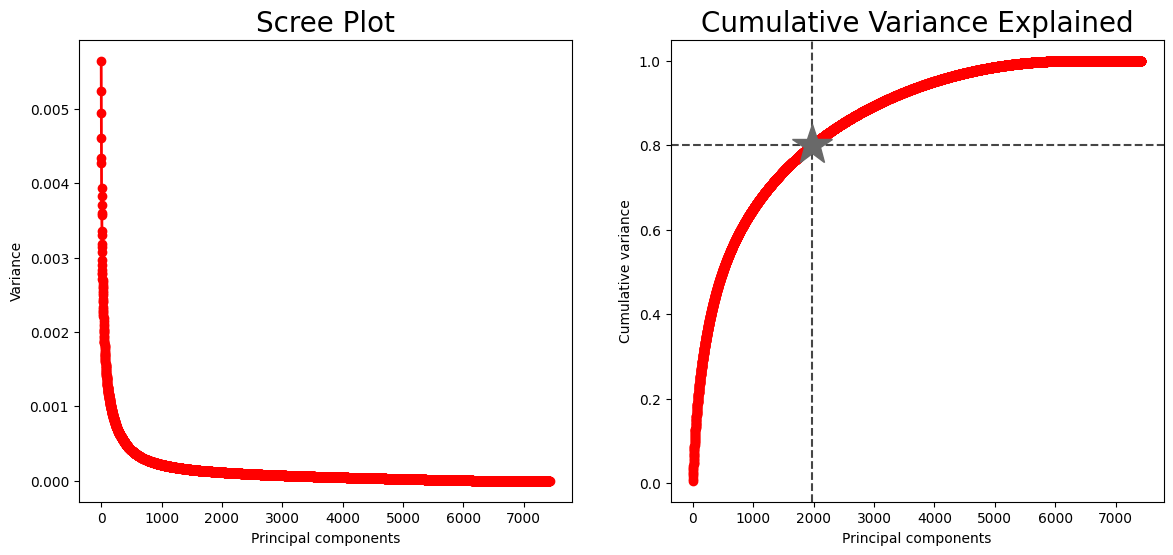

In [4]:
pca = PCAPlotIt(cumulative_variance_target=0.8)
pca.fit(x_train)
pca.generate_plots()

In [5]:
df_train_pcs = pca.transform(x_train)
df_test_pcs = pca.transform(x_test)

In [7]:
# Save trained PCA.
pca.save()

In [8]:
# Build logistic regression classifier.
logit_classifier = LogisticRegression(
    random_state=0,
    penalty="elasticnet",
    l1_ratio=0.5,
    solver="saga",
    n_jobs=-1
)
logit_classifier.fit(df_train_pcs, y_train)

get_model_performance_metrics(
    clf=logit_classifier,
    x_train=df_train_pcs,
    y_train=y_train,
    x_test=df_test_pcs,
    y_test=y_test
)

2023-05-07 22:02:29,057:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 22:02:29,059:INFO:utils:Accuracy: 0.7070543887991384
2023-05-07 22:02:29,061:INFO:utils:ROC AUC: 0.7876884101512385
2023-05-07 22:02:29,062:INFO:utils:Confusion matrix:
[[646 288]
 [256 667]]
2023-05-07 22:02:29,067:INFO:utils:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       934
           1       0.70      0.72      0.71       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.71      1857
weighted avg       0.71      0.71      0.71      1857

2023-05-07 22:02:29,067:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 22:02:34,984:INFO:utils:Cross-validated precision: 0.7183388654557941
2023-05-07 22:02:38,020:INFO:utils:Cross-validated recall: 0.7396130759247243
2023-05-07 22:02:41,052:INFO:utils:Cro

In [10]:
# Apply grid search to tune hyperparameters.
l1_ratio_list = [(l1_ratio / 20) for l1_ratio in list(range(0, 21))]
parameters_logit = {"l1_ratio" : l1_ratio_list}
logit_final = GridSearchCV(
    LogisticRegression(penalty="elasticnet", solver="saga", n_jobs=-1),
    parameters_logit,
    scoring="f1_macro",
    cv=5,
    verbose=1,
    n_jobs=-1
)
logit_final.fit(df_train_pcs, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'l1_ratio': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                      0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
                                      0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]},
             scoring='f1_macro', verbose=1)

In [11]:
# Get and display best results.
best_parameters_gs = gs_display_save_results(
    gscv_fit=logit_final, 
    file_prefix="logreg_pca", 
    save=True
)
best_model = logit_final.best_estimator_

,Params,Mean out-of-bag F1
0,{'l1_ratio': 0.0},0.728663
1,{'l1_ratio': 0.05},0.731235
2,{'l1_ratio': 0.1},0.729084
3,{'l1_ratio': 0.15},0.728397
4,{'l1_ratio': 0.2},0.728264


,Params,Mean out-of-bag F1
16,{'l1_ratio': 0.8},0.722741
17,{'l1_ratio': 0.85},0.722063
18,{'l1_ratio': 0.9},0.721650
19,{'l1_ratio': 0.95},0.720970
20,{'l1_ratio': 1.0},0.718685


2023-05-07 22:03:10,246:INFO:utils:Best parameters: {'l1_ratio': 0.05}. Best mean out-of-bag F1: 0.731235251816927


In [12]:
get_model_performance_metrics(
    clf=best_model,
    x_train=df_train_pcs,
    y_train=y_train,
    x_test=df_test_pcs,
    y_test=y_test
)

2023-05-07 22:03:19,414:INFO:utils:--------------------COMPUTING TEST SET PERFORMANCE METRICS--------------------

2023-05-07 22:03:19,417:INFO:utils:Accuracy: 0.7129779213785676
2023-05-07 22:03:19,419:INFO:utils:ROC AUC: 0.7903447699870778
2023-05-07 22:03:19,420:INFO:utils:Confusion matrix:
[[655 279]
 [254 669]]
2023-05-07 22:03:19,426:INFO:utils:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       934
           1       0.71      0.72      0.72       923

    accuracy                           0.71      1857
   macro avg       0.71      0.71      0.71      1857
weighted avg       0.71      0.71      0.71      1857

2023-05-07 22:03:19,427:INFO:utils:--------------------COMPUTING CROSS-VALIDATED PERFORMANCE METRICS--------------------

2023-05-07 22:03:22,232:INFO:utils:Cross-validated precision: 0.7239653745071051
2023-05-07 22:03:24,742:INFO:utils:Cross-validated recall: 0.7404271871865966
2023-05-07 22:03:27,435:INFO:utils:Cro